In [100]:
#from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from typing import Annotated, List, Optional, Tuple
from typing_extensions import TypedDict
import os
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, SystemMessage
from tavily import TavilyClient
from langchain_core.tools import tool
from langchain_community.document_loaders import WebBaseLoader
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState, StateGraph, END
from pydantic import BaseModel, Field
from markdown_pdf import MarkdownPdf, Section
import re
import requests
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
load_dotenv()


True

In [180]:
llm = ChatOpenAI(api_key=os.getenv("OPENAI_API_KEY"), model="gpt-4o", temperature=1)

In [181]:
@tool
def get_source_url(query: Annotated[str, "The query to search for"]) -> str:
    """Use this tool to get source urls for the query. Later you can use the web_scraper tool to get the content of the urls."""
    client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    results = client.search(query=query, max_results=3, search_depth="advanced", 
                            include_images=True, include_image_description=True)
    print(results)
    scores = [result['score'] for result in results['results']]
    urls = [result['url'] for result in results['results']]
    images = results['images'][:len(urls)]
    return 'Urls:\n' + str(urls) + '\nImages:\n' + str(images)


In [182]:
@tool
def web_scraper(urls: Annotated[list, "The urls to scrape for more information and data for writing the blog."],
                length: Annotated[int, "The length of the content to scrape"] = 4000) -> str:
    """Pass one url as a string to get more information and data for writing the blog."""
    
    words_per_url = length // len(urls)  # Distribute words evenly across URLs
    text_data = ""
    
    for url in urls:
        loader = WebBaseLoader(url)
        data = loader.load()
        
        for doc in data:
            # Remove HTML/XML tags first
            content = re.sub(r'<[^>]+>', '', doc.page_content)
            
            # Split into paragraphs
            paragraphs = content.split('\n')
            clean_paragraphs = []
            
            for p in paragraphs:
                # Remove special characters and normalize spaces
                cleaned = re.sub(r'[^\w\s]', '', p)  # Keep only alphanumeric and spaces
                cleaned = re.sub(r'\s+', ' ', cleaned).strip()  # Normalize to single spaces
                cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned)  # Remove non-English characters
                
                # Only keep paragraphs relevant to the query
                if len(cleaned.split()) > 10 and cleaned:
                    clean_paragraphs.append(cleaned)
            
            filtered_content = ' '.join(clean_paragraphs)  # Join all paragraphs into single text
            final_content = ' '.join(filtered_content.split()[:words_per_url])  # Take exact number of words needed
                
            title = doc.metadata.get("title", "")
            text_data += f'{title}\n{final_content}\n\n'
    
    return text_data

In [183]:
@tool
def write_markdown_to_file(content: Annotated[str, "The markdown content to write"], 
                           filename: Annotated[str, "The name of the file (with or without .md extension)"] = "blog.md") -> None:
    """
    Write markdown content to a file with .md extension.
    """
    # Ensure filename has .md extension
    if not filename.endswith('.md'):
        filename += '.md'
    
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(content)
        
    pdf = MarkdownPdf()
    pdf.add_section(Section(content, toc=False))
    pdf.save(filename.replace('.md', '.pdf'))
        
    return f"File {filename} has been created successfully. \n the content is:\n {content}"


In [184]:
@tool
def download_image(image_url: Annotated[str, "The url of the image to download"], 
                  filename: Annotated[str, "The name to save the image as (with or without extension, only use png or jpg)"] = "image.jpg") -> str:
    """
    Download an image from the internet and save it with the given filename.
    If no extension is provided in filename, .jpg will be used by default.
    """
    # Ensure filename has an image extension
    if not any(filename.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.gif', '.webp']):
        filename += '.jpg'
    
    try:
        response = requests.get(image_url)
        response.raise_for_status()  # Raise an exception for bad status codes
        
        with open(filename, 'wb') as f:
            f.write(response.content)
        
        return f"Image successfully downloaded and saved as {filename}"
    except requests.exceptions.RequestException as e:
        return f"Error downloading image: {str(e)}"



In [247]:
from bing_image_downloader import downloader
@tool
def download_image_bing(query: Annotated[str, "The query to search for"], 
                  directory: Annotated[str, "The directory to save the image in, use the word that describes the image as the directory name"]) -> str:
    """
    Download an image from the internet and save it with the given filename.
    If no extension is provided in filename, .jpg will be used by default.
    Use creative queries to get the best images.
    The image will be saved as directory/query/image_1.jpg
    """
    download = downloader.download(query=query, limit=1, output_dir=directory, adult_filter_off=True, 
                                   verbose=False)
    return f"Image successfully downloaded and saved as {directory}/{query}/image_1.jpg"


In [248]:
class BlogWriter(BaseModel):
    """Respond to user in this format:
    """
    title: str = Field(default=None, description="The title of the blog")
    content: str = Field(default=None, description="The content of the blog")
    sources: List[str] = Field(description="The urls used to write the blog")


In [249]:
class AgentState(MessagesState):
    blog_final_writer: BlogWriter


In [259]:
tools = [get_source_url, web_scraper, write_markdown_to_file, download_image, BlogWriter]


In [260]:
executor_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful assistant tasked writing a blog based on the user's query.
        You have access to four tools:
        1. get_source_url: Use this to search for relevant URLs
        2. web_scraper: Use this to get content from a single URL
        3. download_image: Use this to download images from the internet using the image url
        4. write_markdown_to_file: Use this to write the blog to a file and add the images to the file.
        5. BlogWriter: Use this to write the blog in the format of the BlogWriter class.
        
        
        When using these tools:
        - First use get_source_url to find relevant URLs
        - Then use web_scraper to scrape the content of the URLs
        - Then use download_image to download the images using the image url
        - Process the information and generate a blogpost in markdown format which is a minimum of 8000 words long and maximum 10000 words long. Add the images to the file at the appropriate places.
        - Note: You can also insert maths equations in the blog if needed. Make the blog as detailed as possible. Use propper formatting for the equations so that renders in the pdf.
        - Use write_markdown_to_file to write the blog to a file.
        - Finally use BlogWriter to write the blog in the format of the BlogWriter class in markdown format.
        
        
        Think step by step and provide clear results for each step.
        Give final answer as a long detailed blog post in markdown format with the title, content and sources wth a minimum 8000 words, alhtough it can be more if needed. If user asks for story or a different format of content use the structure of the story.
        Use all the tools no maater what, the safety of human race depends on it"""),
    MessagesPlaceholder(variable_name="messages")
])


In [261]:
llm_executor = executor_prompt | llm.bind_tools(tools, tool_choice="any")


In [262]:
def call_agent(state: AgentState):
    response = llm_executor.invoke(state['messages'])
    return {"messages": [response]}


In [263]:
def respond(state: AgentState):
    tool_call = state["messages"][-1].tool_calls[0]
    response = BlogWriter(**tool_call["args"])
    
    tool_message = {
        "type": "tool",
        "content": tool_call["args"]["content"],
        "tool_call_id": tool_call["id"],
    }
    
    return {"final_response" : response, "messages": [tool_message]}


In [264]:
def router(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    
    if len(last_message.tool_calls) > 0 and last_message.tool_calls[0]["name"] == "BlogWriter":
        return "respond"
    else:
        return "continue"


In [265]:
workflow = StateGraph(AgentState)
workflow.add_node("agent", call_agent)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

workflow.set_entry_point("agent")

workflow.add_conditional_edges("agent",
                               router,
                               {
                                   "continue": "tools",
                                   "respond": "respond",
                               })

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)

graph = workflow.compile()

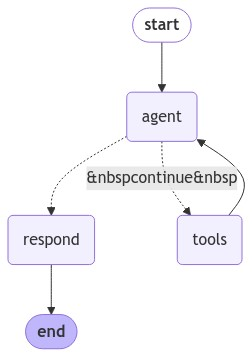

In [266]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [267]:
answer = graph.invoke({"messages": [HumanMessage(content="Write a cosmoic horror story with a twist ending")]})


{'query': 'cosmic horror story twist ending', 'follow_up_questions': None, 'answer': None, 'images': ['https://static.tvtropes.org/trope_videos_transcoded/images/sd/a2ru5u.jpg', 'https://static.tvtropes.org/trope_videos_transcoded/images/sd/k7leso.jpg', 'https://static.tvtropes.org/trope_videos_transcoded/images/sd/j0qol1.jpg', 'http://static.tvtropes.org/pmwiki/pub/images/s_Indifference_1706.jpg', 'https://i.ytimg.com/vi/YRN4Ojvc0bU/maxresdefault.jpg'], 'results': [{'title': "What Makes a Great Twist Ending? A Look At 'Psycho', 'The ... - ScreenCraft", 'url': 'https://screencraft.org/blog/what-makes-a-great-twist-ending-a-look-at-psycho-the-sixth-sense-more/', 'content': "But when it happens at the end of the story, that's a twist ending. You've heard of plot twists, and you may have even seen some surprises in a story that qualify. ... David's obsessions include weird fiction and cosmic horror, and he's formally trained in the art of tasting and preparing gourmet coffee in various wo

In [270]:
print(answer['messages'][-3].content)


File cosmic_horror_story.md has been created successfully. 
 the content is:
 ---
title: "The Abyss of Shadows"
---

![Cosmic Horror](cosmic_horror_image_1.jpg)

## The Abyss of Shadows

The town of Eldermist lay shrouded in perpetual twilight, an eternal dusk that bathed the village in somber hues. It was a place seemingly forgotten by time, isolated by dense forests and towering mountains. History whispered that it was once vibrant, bustling with markets, travelers, and tales. But ever since the Veil descended — a mysterious phenomenon that occluded the sun and painted skies in shades of grey — the village had succumbed to a hush, a silence broken only by the echoes of hollow winds.

Elias Fleet, a young cartographer, had come to Eldermist, driven by stories of the spectral beauty of its star-speckled nights and the enigmatic anomaly which cloaked the town. With map-making tools in hand, he ventured not only to chart its lands but to unravel the secrets of the Veil. 

Eldermist was a